# ADS2 - Assignment 1 - Data Handling and Preparation - Ref/Def

In this assignment, you will be analysing the popularity of films and TV shows on the streaming platform, Amazon Prime. Using your knowledge of PySpark DataFrames and Spark SQL, you will produce a number of "downstream" data products to analyse trends in global streaming habits.

Download the dataset from this [Kaggle](https://www.kaggle.com/datasets/victorsoeiro/amazon-prime-tv-shows-and-movies?select=titles.csv) page. A copy of the `titles.csv` file is also available on the canvas page for this assignment.

Your task is to load in the data and produce a number of "downstream" data products and plots as described below.

The PySpark installation and setup is provided below for conveinience.

In [1]:
# Apache Spark uses Java, so first we must install that
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and unpack the latest version of Spark (3.2.0 as of writing)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# Set up environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# Install findspark, which helps python locate the psyspark module files
!pip install -q findspark
import findspark
findspark.init()

# Finally, we initialse a "SparkSession", which handles the computations
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# pyspark.sql.functions countains all the transformations and actions you will
# need
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, StringType, StructType, StructField, LongType

In [2]:
# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# remove pandas warnings
pd.set_option('mode.chained_assignment', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exercise 1 - Data Preparation (5 Marks)


1.   Load the `titles.csv` into your Colab Notebook as a DataFrame.
2.   Create two separate DataFrames for the MOVIE and SHOW categories.
3.   For the MOVIE data, drop the column containing the number of seasons.
4.   For both dataframes, drop the 'tmdb_popularity' and 'tmdb_score' columns.

In [6]:
# Dataset path variable
PATH_TITLES = '/content/drive/MyDrive/Colab Notebooks/titles.csv'

In [7]:
""" 1.1 """

# Load the titles.csv into your Colab Notebook as a DataFrame. Take care to ensure the schema is defined

# set datatype for each column
userDefinedSchema = StructType([
    StructField("id", StringType(), True),
    StructField("title", StringType(), True),
    StructField("type", StringType(), True),
    StructField("description", StringType(), True),
    StructField("release_year", LongType(), True),
    StructField("age_certification", StringType(), True),
    StructField("runtime", LongType(), True),
    StructField("genres", StringType(), True),
    StructField("production_countries", StringType(), True),
    StructField("seasons", DoubleType(), True),
    StructField("imdb_id", StringType(), True),
    StructField("imdb_score", DoubleType(), True),
    StructField("imdb_votes", DoubleType(), True),
    StructField("tmdb_popularity", DoubleType(), True),
    StructField("tmdb_score", DoubleType(), True),
])

# read data as pyspark df
df = spark.read\
          .option("header", "true")\
          .schema(userDefinedSchema)\
          .csv(PATH_TITLES)

# Display the table and its schema
df.show()

# Display df datatypes for each column
df.printSchema()

# Display table's shape
print('df shape:', f'({df.count()}, {len(df.columns)})')

+--------+--------------------+-----+--------------------+------------+--------------------+-------+--------------------+--------------------+-------+----------+----------+----------+---------------+----------+
|      id|               title| type|         description|release_year|   age_certification|runtime|              genres|production_countries|seasons|   imdb_id|imdb_score|imdb_votes|tmdb_popularity|tmdb_score|
+--------+--------------------+-----+--------------------+------------+--------------------+-------+--------------------+--------------------+-------+----------+----------+----------+---------------+----------+
| ts20945|   The Three Stooges| SHOW|The Three Stooges...|        1934|               TV-PG|     19|['comedy', 'famil...|              ['US']|   26.0| tt0850645|       8.6|    1092.0|         15.424|       7.6|
| tm19248|         The General|MOVIE|During America’s ...|        1926|                null|     78|['action', 'drama...|              ['US']|   null| tt001

In [8]:
""" 1.2 """

# Seperate the data into two DataFrames for MOVIE and SHOW
df_movie = df.filter(df['type']=="MOVIE")
df_show = df.filter(df['type']=="SHOW")

# Display both tables' shape
print('MOVIE df shape:', f'({df_movie.count()}, {len(df_movie.columns)})')
print('SHOW df shape:', f'({df_show.count()}, {len(df_show.columns)})')

MOVIE df shape: (8514, 15)
SHOW df shape: (1357, 15)


In [9]:
""" 1.3 & 1.4 """

# Drop the 'seasons' column from the MOVIE df
# Drop both the 'tmdb_popularity' and 'tmdb_score' coloumns from both MOVIE and SHOW dfs
df_movie = df_movie.drop('seasons', 'tmdb_popularity', 'tmdb_score')
df_show = df_show.drop('tmdb_popularity', 'tmdb_score')

# Display both tables' shape
print('MOVIE df shape:', f'({df_movie.count()}, {len(df_movie.columns)})')
print('SHOW df shape:', f'({df_show.count()}, {len(df_show.columns)})')

MOVIE df shape: (8514, 12)
SHOW df shape: (1357, 13)


# Exercise 2 - Highest and lowest rated shows (15 Marks)

1.   For each country in the 'production_countries' column, find the SHOW that scored the highest and lowest in the 'imdb_score' column.
2.   Calculate the mean, mode and median 'imdb_score' for each country in the 'production_countries' column.
3.   Produce a count for each unique genre among the highest rated SHOW from each production country. Display this in a bar chart or histogram.


In [10]:
""" 2.1 & 2.2 """

### Group the data by 'production_countries', find the highest scoring and
### lowest scoring SHOW. Calculate the mean, mode and median score for each
### country. Sort by country and display the data.
# .groupBy, .agg, F.max, F.min, F.mean, F.median, F.mode, .sort, .show

df_2_2 = df_show\
              .na.drop()\
              .sort(  
                      F.col('imdb_score').desc()  
                  )\
              .groupBy('production_countries')\
              .agg( 
                    F.first('title').alias('Highest Scoring Show'), 
                    F.last('title').alias('Lowest Scoring Show'),
                    F.mean('imdb_score').alias('Mean'),
                    F.percentile_approx('imdb_score', 0.5).alias('Median'),
                  )
df_2_2.show()

+--------------------+--------------------+--------------------+-----------------+------+
|production_countries|Highest Scoring Show| Lowest Scoring Show|             Mean|Median|
+--------------------+--------------------+--------------------+-----------------+------+
|        ['US', 'GB']|Shakespeare Uncov...|           Cocomelon|6.933333333333334|   7.4|
|  ['IL', 'PH', 'ES']|          Lucky Fred|          Lucky Fred|              6.4|   6.4|
|        ['GB', 'NL']|             Morphle|             Morphle|              5.1|   5.1|
|        ['KR', 'JP']|          Mix Master|          Mix Master|              8.2|   8.2|
|  ['CA', 'AU', 'US']|     The Saddle Club|     The Saddle Club|              5.9|   5.9|
|        ['GB', 'US']|     Wheeler Dealers|           One Child|             7.32|   7.2|
|              ['KR']|   Boys Over Flowers|부릉! 부릉! 브루미즈|6.544444444444444|   6.6|
|  ['US', 'GB', 'CA']|The Cat in the Ha...|The Cat in the Ha...|              6.4|   6.4|
|              ['D

In [11]:
""" 2.3 - Function """

# function to get unique genres & their respective counts in df format
def get_df_genres_count(df):

  # remove all missing values
  df = df.dropna(subset=['genres'])

  # create list to store unique genres
  list_genres, list_count_genres = [], []

  # since genre in 'genres' are written as list format,
  # for each value in the column, perform the following...
  for i in df['genres']:

    # filter to only strings with 'list' format
    if (']' in i) and ('[' in i):

      # remove the list brackets, and split the data by commas, ending up with a list
      i = i.strip("][").split(', ')

      # replace unwanted characters
      for genre in i:
        genre = genre.replace("'", '')

        # to get unique genres, only add genre that are not yet present in the genre list
        if (genre not in list_genres) and (len(genre)>0):
          list_genres.append(genre)

  # get count for each genre
  for genre in list_genres:
    count_genre = 0
    for i in df['genres']:
      if genre in i:
        count_genre += 1
    list_count_genres.append(count_genre)

  # create df from results
  df_genres_count = pd.DataFrame()
  df_genres_count['Genres'] = list_genres
  df_genres_count['Count'] = list_count_genres
  df_genres_count = df_genres_count.sort_values('Count')
  df_genres_count = df_genres_count.set_index('Genres')

  return df_genres_count

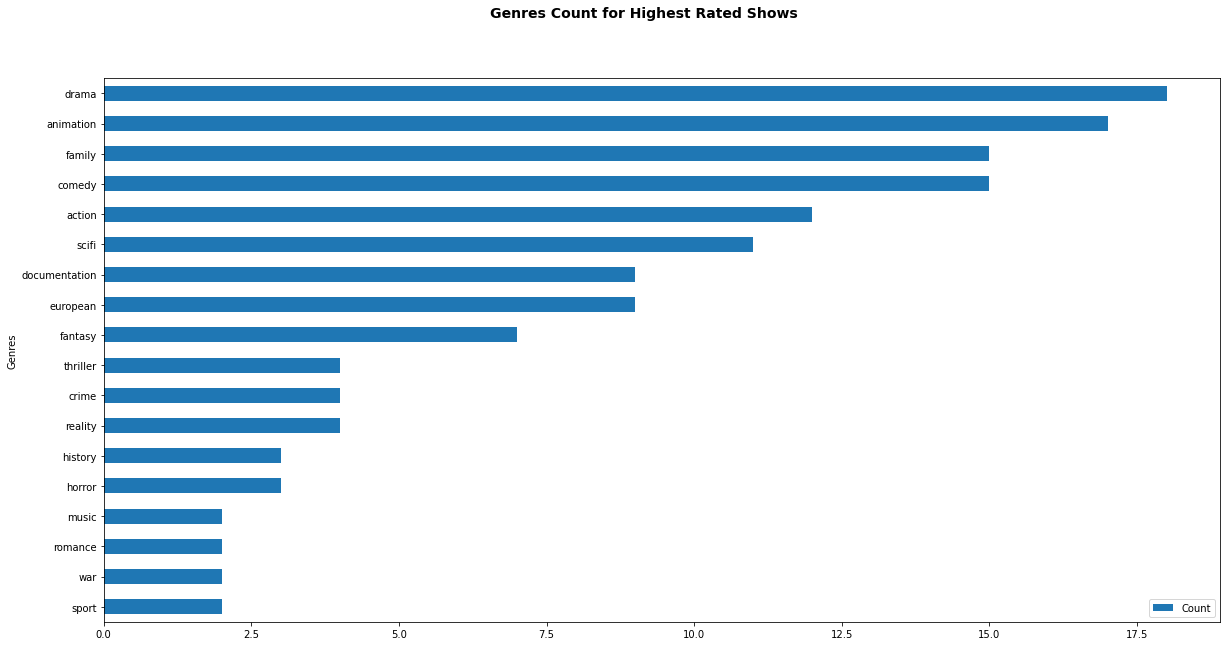

In [12]:
""" 2.3 """

### Count the number of times each individual genre label appears amongst the
### highest rated shows. Display this in a bar chart or histrogram.

### Since PySpark doesn't have any plotting functionality, Pandas and Matplotlib will be used for this section instead

# convert spark df to pandas df
df_2_2 = df_2_2.toPandas()
df_2_3 = df_show.toPandas()

# get highest scoring shows
list_shows_highest = df_2_2['Highest Scoring Show'].unique()

# filter df to only highest scoring shows
df_2_3 = df_2_3.loc[df_2_3['title'].isin(list_shows_highest)]

# get unique genres & their respective counts
df_2_3 = get_df_genres_count(df_2_3)

# plot histogram from results
df_2_3.plot.barh(figsize=(20, 10))
plt.suptitle('Genres Count for Highest Rated Shows', fontweight='bold', fontsize=14)

# convert pandas df back to spark df
df_2_2 = spark.createDataFrame(df_2_2)

# Exercise 3 - Highest Rated Shows Over Time (10 Marks)


1.   Find the highest rated and lowest rated SHOW, and the mean, median and mode imdb score by production country and year of release.
2.   Produce a scatter plot of all entries in the SHOW dataframe, displaying year of release on the x-axis and imdb score in the y-axis.

In [13]:
""" 3.1 """

### Group the data by 'production_countries' and 'release_year', find the
### highest scoring and lowest scoring SHOW. Calculate the mean, mode and median
### score for each country. Sort by country and display the data.
# .groupBy, .agg, F.max, F.min, F.mean, F.median, F.mode, .sort, .show

df_3_1 = df_show\
              .na.drop()\
              .sort(  
                      F.col('imdb_score').desc()  
                  )\
              .groupBy('production_countries', 'release_year')\
              .agg( 
                    F.first('title').alias('Highest Scoring Show'),  
                    F.last('title').alias('Lowest Scoring Show'),
                    F.mean('imdb_score').alias('Mean'),
                    F.percentile_approx('imdb_score', 0.5).alias('Median'),
                  )
df_3_1.show()

+--------------------+------------+--------------------+--------------------+-----------------+------+
|production_countries|release_year|Highest Scoring Show| Lowest Scoring Show|             Mean|Median|
+--------------------+------------+--------------------+--------------------+-----------------+------+
|  ['AT', 'GB', 'US']|        2012|        On Death Row|        On Death Row|              7.9|   7.9|
|              ['AU']|        1988|       Home and Away|       Home and Away|              5.1|   5.1|
|              ['AU']|        1998|   A Difficult Woman|   A Difficult Woman|              6.5|   6.5|
|              ['AU']|        2006| H2O: Just Add Water|     Dive Olly Dive!|             6.65|   6.1|
|              ['AU']|        2010|    My Kitchen Rules|       Dance Academy|              7.6|   7.1|
|              ['AU']|        2011|  Bananas in Pyjamas|  Bananas in Pyjamas|              4.3|   4.3|
|              ['AU']|        2012|Guess How Much I ...|Guess How Much I 

Text(0.5, 0.98, 'Release Year VS IMDB Score')

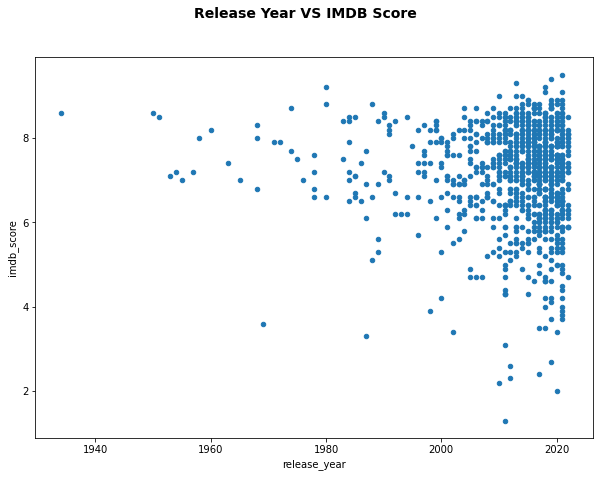

In [14]:
""" 3.2 """

### Produce a scatter plot of release year against imdb_score.

### Since PySpark doesn't have any plotting functionality, Pandas and Matplotlib will be used for this section instead

# convert spark df to pandas df
df_3_2 = df_show.toPandas()

# create scatter plot from results
df_3_2.plot.scatter(x='release_year', y='imdb_score', figsize=(10, 7))
plt.suptitle('Release Year VS IMDB Score', fontweight='bold', fontsize=14)

# Exercise 4 - Movie Popularity Analysis (15 Marks)

Analyse the MOVIE dataframe and comment on the following aspects (write your comments into the text box below). You can produce plots, use statistic methods such as correlations, or aggregate queries on groupings in the dataframe.

1.   How does MOVIE popularity relate to runtime? Consider how runtimes have changed over the years, and how that affects popularity.
2.   How has the distribution of film genres changed over time?
3.   What is the relationship between age certification, production country and popularity?
4.   Amongst the top 100 movies by imdb score, what similarties are there? Are there any movies that don't fit with the rest? Apply a cut off for the minimum number of imdb votes and see how the data changes.



Text(0.5, 1.0, 'Movie Release Year VS Runtime')

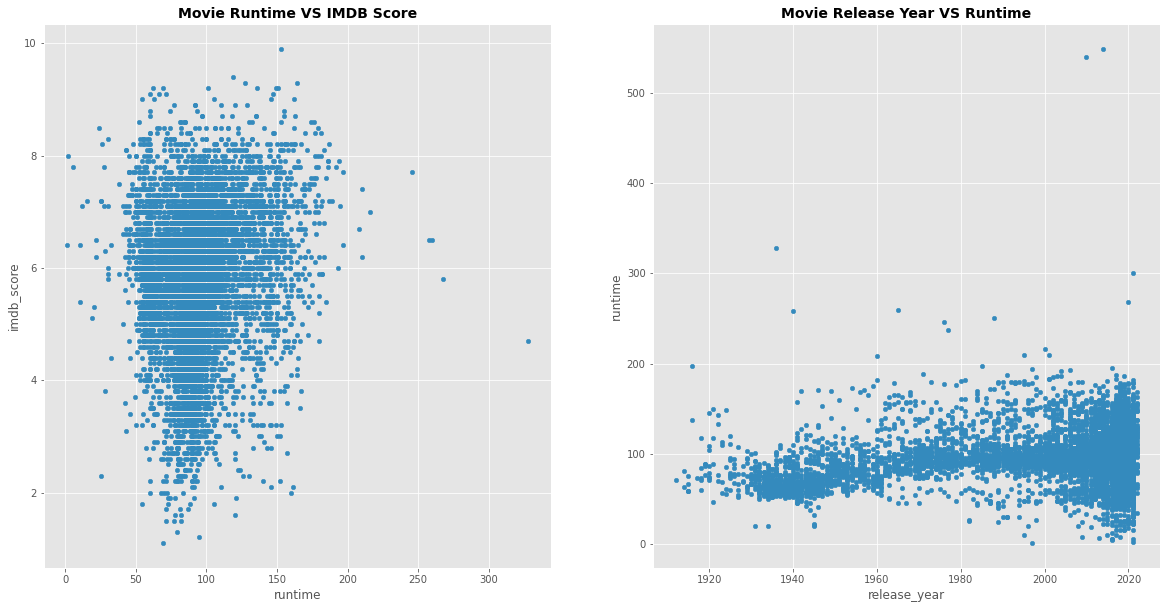

In [15]:
""" 4.1 """

### How does MOVIE popularity relate to runtime?
### Consider how runtimes have changed over the years, and how that affects popularity.

# using the 'imdb_score' column because 'tmdb_popularity' column have been dropped earlier
df_4_1a = df_movie\
                .select('imdb_score', 'runtime')\
                .na.drop()\
                .sort(F.col('imdb_score').desc())

df_4_1b = df_movie\
                .select('release_year', 'runtime')\
                .na.drop()\
                .sort(F.col('release_year'))

### Since PySpark doesn't have any plotting functionality, Pandas and Matplotlib will be used for this section instead

# convert spark df to pandas df
df_4_1a = df_4_1a.toPandas()
df_4_1b = df_4_1b.toPandas()

# set basic plotting configurations
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.flatten()

# create scatter plot from results
df_4_1a.plot.scatter(x='runtime', y='imdb_score', ax=ax[0])
df_4_1b.plot.scatter(x='release_year', y='runtime', ax=ax[1])
ax[0].set_title('Movie Runtime VS IMDB Score', fontweight='bold', fontsize=14)
ax[1].set_title('Movie Release Year VS Runtime', fontweight='bold', fontsize=14)

In [16]:
""" 4.2 - Function """

# function to categorize 'genres' column
def get_df_genres_categorized(df, list_genres):

  # remove all missing values in genres column
  df = df.dropna(subset=['genres'])

  # create a column for each respective genre
  for genre in list_genres:
    df[genre] = [int(genre in x) for x in df['genres']]

  return df

Text(0.5, 0.98, 'Movies Release Year VS Genres Count')

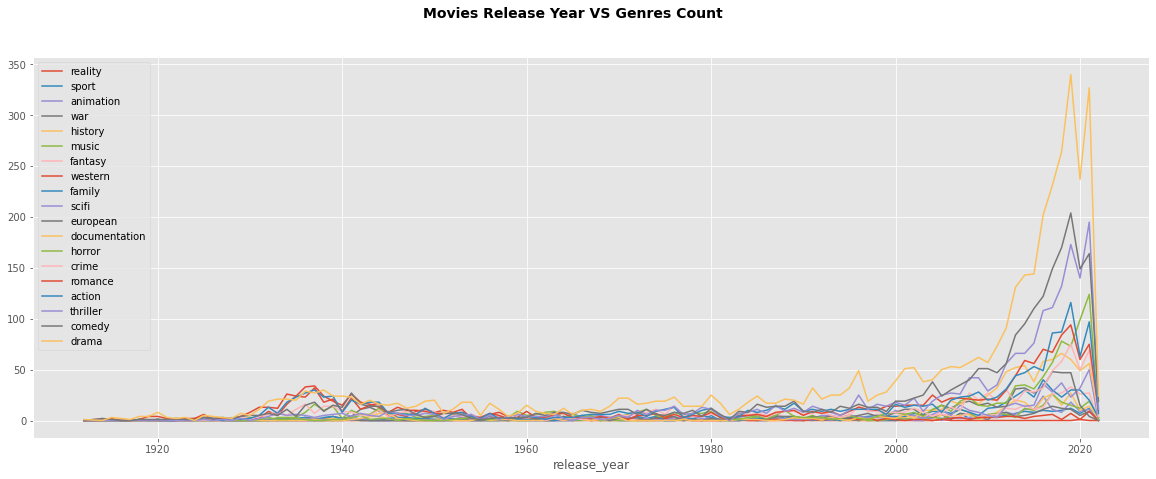

In [17]:
""" 4.2 """

### How has the distribution of film genres changed over time?

### Since PySpark doesn't have any plotting functionality, Pandas and Matplotlib will be used for this section instead

# convert spark df to pandas df
df_4_2 = df_movie.toPandas()

# get unique genres & their respective counts in df format
df_genres_count = get_df_genres_count(df_4_2)

# get list of unique genres from df_genres_count
list_genres = df_genres_count.index

# categorize 'genres' column
df_4_2 = get_df_genres_categorized(df_4_2, list_genres)

# groupby 'release_year' with sum aggregate function
df_4_2 = df_4_2.groupby('release_year').sum()

# filter df to only categorized genres columns
df_4_2 = df_4_2[list_genres]

# plot graph from results
df_4_2.plot.line(figsize=(20, 7))
plt.suptitle('Movies Release Year VS Genres Count', fontweight='bold', fontsize=14)

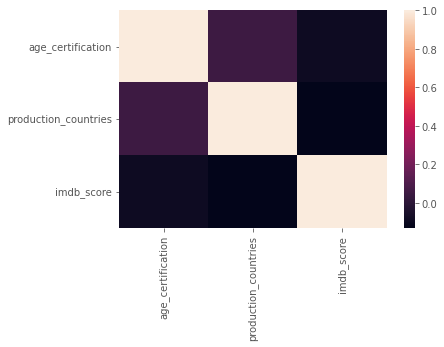

In [18]:
""" 4.3 """

### What is the relationship between age certification, production country and popularity?

df_4_3 = df_movie\
            .na.drop()\
            .select(
                F.col('age_certification'), 
                F.col('production_countries'), 
                F.col('imdb_score'))

### Since PySpark doesn't have any plotting functionality, Pandas and Matplotlib will be used for this section instead

# convert spark df to pandas df
df_4_3 = df_4_3.toPandas()

# in order to create correlation matrix, all data have to be in numerical format
# categorize non-numeric data as numeric categorical codes
df_4_3['age_certification'] = df_4_3['age_certification'].astype('category').cat.codes
df_4_3['production_countries'] = df_4_3['production_countries'].astype('category').cat.codes

# generate correlation matrix
correlation_matrix = df_4_3.corr()

# plot correlation matrix
plt.style.use('ggplot')
sns.heatmap(correlation_matrix)

In [19]:
""" 4.4 """

### Amongst the top 100 movies by imdb score, what similarties are there? Are
### there any movies that don't fit with the rest? Apply a cut off for the
### minimum number of imdb votes and see how the data changes.

# filter columns to only show relevant movie details & prevent clutter
# sort values by 'imdb_score', and get only the top 100 rows
df_4_4a = df_movie\
            .na.drop()\
            .select(
                F.col('title'),
                F.col('release_year'),
                F.col('age_certification'),
                F.col('runtime'),
                F.col('genres'),
                F.col('production_countries'),
                F.col('imdb_score'),
                F.col('imdb_votes')
            )\
            .sort(F.col('imdb_score').desc())\
            .limit(100)

# display queried df
df_4_4a.show(100)

+--------------------+------------+-----------------+-------+--------------------+--------------------+----------+----------+
|               title|release_year|age_certification|runtime|              genres|production_countries|imdb_score|imdb_votes|
+--------------------+------------+-----------------+-------+--------------------+--------------------+----------+----------+
|               Quota|        2020|                G|    101| ['family', 'drama']|              ['IN']|       9.2|     306.0|
|Florence Foster J...|        2016|            PG-13|    110|['drama', 'crime'...|        ['US', 'GB']|       8.9|       9.0|
|The Friendliest Town|        2019|            PG-13|     77|   ['documentation']|              ['US']|       8.9|      15.0|
|           Chocolate|        2008|                R|     93|['comedy', 'docum...|              ['TH']|       8.8|      65.0|
|   Pariyerum Perumal|        2018|               PG|    155|['romance', 'drama']|              ['IN']|       8.8|   1

In [20]:
""" 4.4 """

# filter columns to only show relevant movie details & prevent clutter
# sort values by 'imdb_score', and get only the top 100 rows

df_4_4b = df_movie.filter(F.col('imdb_votes')>1000)
df_4_4b = df_4_4b\
            .na.drop()\
            .select(
                F.col('title'),
                F.col('release_year'),
                F.col('age_certification'),
                F.col('runtime'),
                F.col('genres'),
                F.col('production_countries'),
                F.col('imdb_score'),
                F.col('imdb_votes')
            )\
            .sort(F.col('imdb_score').desc())\
            .limit(100)

# display queried df
df_4_4b.show(100)

+--------------------+------------+-----------------+-------+--------------------+--------------------+----------+----------+
|               title|release_year|age_certification|runtime|              genres|production_countries|imdb_score|imdb_votes|
+--------------------+------------+-----------------+-------+--------------------+--------------------+----------+----------+
|   Pariyerum Perumal|        2018|               PG|    155|['romance', 'drama']|              ['IN']|       8.8|   15150.0|
|        Sardar Udham|        2021|                R|    163|['drama', 'histor...|  ['IN', 'RU', 'GB']|       8.7|   38921.0|
|It's a Wonderful ...|        1946|               PG|    130|['drama', 'family...|              ['US']|       8.6|  444243.0|
|            Mahanati|        2018|               PG|    176|           ['drama']|              ['IN']|       8.6|   12056.0|
|  The Usual Suspects|        1995|                R|    106|['thriller', 'cri...|              ['US']|       8.5| 105

# Evaluation

### 4.1

The first chart on the left displays the Movie Runtime VS IMDB Score. Unfortunately, because there are no linear nor parabolic pattern in the graph, we couldn’t really conclude if there are any relationship between the two variables. Alternatively, we could visually see that most of the data points are ‘clustered’ within Movie Runtime of 50 & 150, and IMDB Scores of 3 & 8. This shows that most movies are made within those runtime ranges, and are scored by the public within those scoring ranges.

For the second chart on the right, displaying the Release Year VS Movie Runtime, it could be seen that as time passes, more and more data are present in the chart. This may reflect the performance of the growing demand and popularity of the filming and cinematic industry over the past century. Also, the dispersion of runtimes are broadening too, conveying that the mainstream lengths of movies are becoming more flexible than ever before.

### 4.2

The chart above displays Movies’ Release Year VS Genres Count trend-line (for each individual genre) over the years. From this graph, we could clearly see that ‘Drama’ is the most popular genre for movies for about nearly 6 decades. Additionally, if we look much closely, we could see that in the late 1930s, there was a surge in ‘Western’ genre movies, but that quickly sank back down in the 1940s. Unfortunately, since there are many different types of genres present in the dataset, it is difficult to distinguish the other least obvious trends due to the tangles within each lines. 

However again, similar to that of 4.1, we could see majority of the trend-lines increasing, which may be due to the fact that there are more and more movies being created every year as time goes by. 

### 4.3

The correlation matrix plot above conveys the relationship between Production Countries, Age Certification, and IMDB Score of all the movies in the dataset. From here, we could see that the IMDB Score of movies has no relationship with both the Production Countries and Age Certification. However, it seems that there is a slight relation between the movies’ Production Countries and Age Certification. Intuitively, this may be due to the local regulations present from each respective country.

### 4.4

The first table above prints the details of the top 100 movies (by IMDB Score). From the table, we could see that majority of these films are released between the late 20th century up to the present year. Additionally, most of these movies are PG-13 age certified, are of more than 100 minutes of runtime, and are mostly produced in the United States. Also, it consists a wide variety of genres, but we could notably see that most of these movies have a ‘Drama’ as one of their genres. 

Unfortunately, we couldn’t directly pick any movies that may not be suitable in the dataset, as there are a diverse amount of variables. However alternatively, if we look closely at the IMDB Votes column, we could see that not all movies are of very similar ranges of votes. Logically, this clearly affects the IMDB Score as it supposedly takes the average scores of these votes. Therefore, the lesser the vote count, the more bias the data may be.

To address this issue, before we repeat the same steps to query the top 100 movies, this time priorly filter the movies data to only IMDB Votes of more than 1000. This results the second printed table above. Of course, if we compare the Title columns between the 2 resulting tables, we could see that the movies have either been filtered out, or reordered by ranks, as expected. As compared to the first table, we couldn’t really identify much differences in conclusions from the Release Year, Runtime, Genres, and Production Countries columns. However, for the Age Certifications, it could be seen that there are not as much PG-13 rated anymore, however it is still be the majority certification in the table. Last but not least, the highest IMDB Score is 8.8, and no longer 9.2. This shows that we have successfully removed the bias skews in the data.